In [1]:
import pandas as pd
import numpy as np
from train_gp import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns
import random



In [2]:
big_dataset_path = 'data\Data training DGA Multi-Method.xlsx'
small_dataset_path = 'data\DGA TC10.xlsx'

In [ ]:
# Read the training data
big_dataset = pd.read_excel(big_dataset_path, sheet_name='multi-method')
# Remove unnecessary feature from training data
big_dataset = big_dataset.iloc[:, list(range(6)) + [-1]]
big_dataset = big_dataset.dropna()

# Reset the index after dropping rows
big_dataset.reset_index(drop=True, inplace=True)
print(big_dataset.head())

343


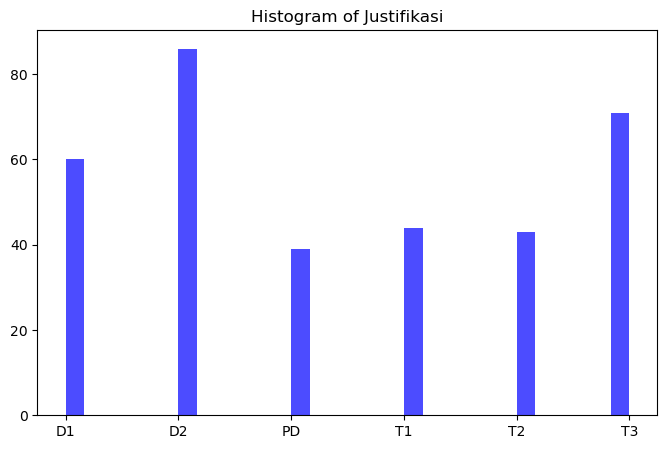

In [3]:
# Read the test data
small_dataset = pd.read_excel(small_dataset_path, sheet_name='Sheet1')
small_dataset = transform_small_dataset(small_dataset)
print(len(small_dataset))

# Plot histogram of Justifikasi column
plt.figure(figsize=(8, 5))
plt.hist(small_dataset['Justifikasi'].astype(str), bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Justifikasi')
plt.show()

In [ ]:
small_dataset

In [ ]:
# Plot pairplot
sns.pairplot(small_dataset, hue='Justifikasi', palette='tab10')
plt.suptitle("Pairplot of Features Colored by Class", y=1.02)
plt.show()


# PCA

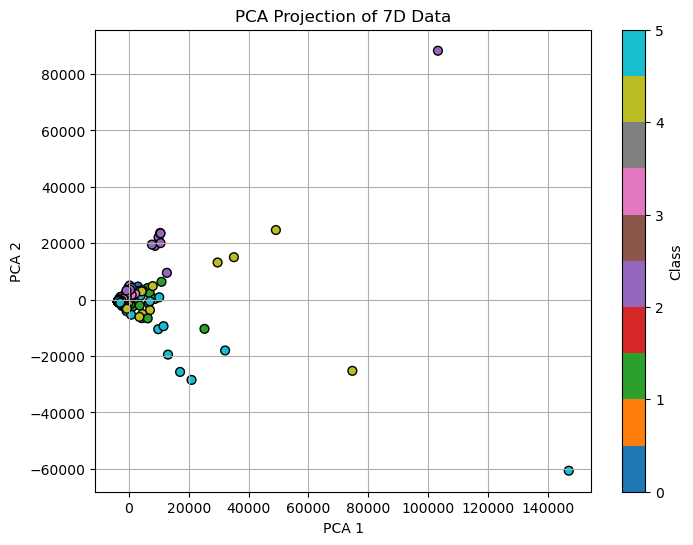

In [4]:
X_pca = small_dataset.iloc[:, :-1].to_numpy()
y_pca = small_dataset["Justifikasi"]
y_pca = y_pca.map(encode_justifikasi).to_numpy()
# Reduce dimensions from 7D to 2D
pca_2D = PCA(n_components=2)
X_reduced = pca_2D.fit_transform(X_pca)

# Plot with class colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pca, cmap='tab10', s=40, edgecolor='k')
plt.title('PCA Projection of 7D Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Class')
plt.grid(True)
plt.show()


In [ ]:
# Reduce dimensions from 7D to 3D
pca = PCA(n_components=3)
X_reduced3D = pca.fit_transform(X)

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

# Mapping from numerical value to class name
label_map = {0: "D1", 1: "D2", 2: "PD", 3: "T1", 4: "T2", 5: "T3"}

# Plot with class colors and add legend
for class_value, class_name in label_map.items():
    idx = y == class_value
    ax.scatter(
        X_reduced3D[idx, 0],
        X_reduced3D[idx, 1],
        X_reduced3D[idx, 2],
        label=class_name,
        s=40,
    )

ax.set(
    title="First three PCA dimensions",
    xlabel="1st Eigenvector",
    ylabel="2nd Eigenvector",
    zlabel="3rd Eigenvector",
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.legend(title="Justifikasi")
plt.show()

In [ ]:
len(small_dataset)

# Gaussian Process Classificiation

In [5]:
def print_report(reports_name: List[str], reports: Dict[str, ClassificationReport]):
    class_count = 6
    for name in reports_name:
        name_splitted = name.split("_")
        report_name = name_splitted[0]
        selected_class_data_count = int(name_splitted[1])
        rest_of_class_data_count = int(name_splitted[2]) * (class_count - 1)
        print("=" * 40)
        print(f"Classifier: {report_name}")
        print("-" * 40)
        print("Training Data Distribution:")
        print(f"  Selected class samples : {selected_class_data_count}")
        print(f"  Rest of class samples  : {rest_of_class_data_count}")
        print("-" * 40)
        print("Training Accuracy:")
        print(f"  Correct predictions on sampled test data   : {reports[name].correct_prediction_count}")
        print(f"  Incorrect predictions on sampled test data : {reports[name].incorrect_prediction_count}")
        print(f"  Percentage of correct prediction : {reports[name].correct_percentage} %")
        print("=" * 40 + "\n")



## D1 vs R

In [6]:
D1VsR_data_generator = OneVsRestDataExtraction(small_dataset,"D1",random_state=100)
D1VsR_reports_name = ["D1vsR_10_5","D1vsR_15_5","D1vsR_20_10","D1vsR_25_10","D1vsR_30_15","D1vsR_35_15"]

In [7]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
D1vsR_gpc = GaussianProcessClassifier(kernel=rbf, n_restarts_optimizer=20, max_iter_predict=300, random_state=3)

In [8]:
D1vsR_reports = train_onevsrest_gpc_with_data_variation(D1vsR_gpc,
                                        D1VsR_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        D1VsR_reports_name)

c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [9]:
print_report(D1VsR_reports_name, D1vsR_reports)

Classifier: D1vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 258
  Incorrect predictions on sampled test data : 50
  Percentage of correct prediction : 83.76623376623377 %

Classifier: D1vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 220
  Incorrect predictions on sampled test data : 83
  Percentage of correct prediction : 72.60726072607261 %

Classifier: D1vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 242
  Incorrec

### With PCA

In [10]:
D1VsR_PCA_data_generator = OneVsRestDataExtraction((X_reduced, small_dataset["Justifikasi"].to_numpy()), "D1", random_state=100)
D1VsR_PCA_reports_name = ["D1vsRPCA_10_5","D1vsRPCA_15_5","D1vsRPCA_20_10","D1vsRPCA_25_10","D1vsRPCA_30_15","D1vsRPCA_35_15"]

In [11]:
D1vsR_PCA_reports = train_onevsrest_gpc_with_data_variation(D1vsR_gpc,
                                        D1VsR_PCA_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        D1VsR_PCA_reports_name)


c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-p

In [12]:
print_report(D1VsR_PCA_reports_name, D1vsR_PCA_reports)

Classifier: D1vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 232
  Incorrect predictions on sampled test data : 76
  Percentage of correct prediction : 75.32467532467533 %

Classifier: D1vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 258
  Incorrect predictions on sampled test data : 45
  Percentage of correct prediction : 85.14851485148515 %

Classifier: D1vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 233
 

## D2 vs R

In [13]:
D2VsR_data_generator = OneVsRestDataExtraction(small_dataset,"D2",random_state=100)
D2VsR_reports_name = ["D2vsR_10_5","D2vsR_15_5","D2vsR_20_10","D2vsR_25_10","D2vsR_30_15","D2vsR_35_15"]

In [14]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
D2vsR_gpc = GaussianProcessClassifier(kernel=rbf, n_restarts_optimizer=15, max_iter_predict=300, random_state=10)

In [15]:
D2vsR_reports = train_onevsrest_gpc_with_data_variation(D2vsR_gpc,
                                        D2VsR_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        D2VsR_reports_name)

c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [16]:
print_report(D2VsR_reports_name, D2vsR_reports)

Classifier: D2vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 229
  Incorrect predictions on sampled test data : 79
  Percentage of correct prediction : 74.35064935064936 %

Classifier: D2vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 216
  Incorrect predictions on sampled test data : 87
  Percentage of correct prediction : 71.28712871287128 %

Classifier: D2vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 205
  Incorrec

### With PCA

In [17]:
D2VsR_PCA_data_generator = OneVsRestDataExtraction((X_reduced, small_dataset["Justifikasi"].to_numpy()), "D2", random_state=120)
D2VsR_PCA_reports_name = ["D2vsRPCA_10_5","D2vsRPCA_15_5","D2vsRPCA_20_10","D2vsRPCA_25_10","D2vsRPCA_30_15","D2vsRPCA_35_15"]

In [18]:
D2vsR_PCA_reports = train_onevsrest_gpc_with_data_variation(D2vsR_gpc,
                                        D2VsR_PCA_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        D2VsR_PCA_reports_name)


c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [19]:
print_report(D2VsR_PCA_reports_name, D2vsR_PCA_reports)

Classifier: D2vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 232
  Incorrect predictions on sampled test data : 76
  Percentage of correct prediction : 75.32467532467533 %

Classifier: D2vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 204
  Incorrect predictions on sampled test data : 99
  Percentage of correct prediction : 67.32673267326733 %

Classifier: D2vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 204
 

## PD vs R

In [24]:
PDVsR_data_generator = OneVsRestDataExtraction(small_dataset,"PD",random_state=90)
PDVsR_reports_name = ["PDvsR_10_5","PDvsR_15_5","PDvsR_20_10","PDvsR_25_10","PDvsR_30_15","PDvsR_35_15"]

In [25]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
PDvsR_gpc = GaussianProcessClassifier(kernel=rbf, n_restarts_optimizer=15, max_iter_predict=400, random_state=11)

In [26]:
PDvsR_reports = train_onevsrest_gpc_with_data_variation(PDvsR_gpc,
                                        PDVsR_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        PDVsR_reports_name)

c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.ht

In [27]:
print_report(PDVsR_reports_name, PDvsR_reports)

Classifier: PDvsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 279
  Incorrect predictions on sampled test data : 29
  Percentage of correct prediction : 90.5844155844156 %

Classifier: PDvsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 289
  Incorrect predictions on sampled test data : 14
  Percentage of correct prediction : 95.37953795379538 %

Classifier: PDvsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 263
  Incorrect

### With PCA

In [32]:
PDVsR_PCA_data_generator = OneVsRestDataExtraction((X_reduced, small_dataset["Justifikasi"].to_numpy()), "PD", random_state=121)
PDVsR_PCA_reports_name = ["PDvsRPCA_10_5","PDvsRPCA_15_5","PDvsRPCA_20_10","PDvsRPCA_25_10","PDvsRPCA_30_15","PDvsRPCA_35_15"]

In [33]:
PDvsR_PCA_reports = train_onevsrest_gpc_with_data_variation(PDvsR_gpc,
                                        PDVsR_PCA_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        PDVsR_PCA_reports_name)


c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\_gpc.py:456: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum()


In [34]:
print_report(PDVsR_PCA_reports_name, PDvsR_PCA_reports)

Classifier: PDvsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 273
  Incorrect predictions on sampled test data : 35
  Percentage of correct prediction : 88.63636363636364 %

Classifier: PDvsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 255
  Incorrect predictions on sampled test data : 48
  Percentage of correct prediction : 84.15841584158416 %

Classifier: PDvsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 254
 

## T1 vs R

In [ ]:
T1VsR_data_generator = OneVsRestDataExtraction(small_dataset,"T1",random_state=95)
T1VsR_reports_name = ["T1vsR_10_5","T1vsR_15_5","T1vsR_20_10","T1vsR_25_10","T1vsR_30_15","T1vsR_35_15"]

In [ ]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
T1vsR_gpc = GaussianProcessClassifier(kernel=rbf, n_restarts_optimizer=15, max_iter_predict=300, random_state=29)

In [39]:
T1vsR_reports = train_onevsrest_gpc_with_data_variation(T1vsR_gpc,
                                        T1VsR_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        T1VsR_reports_name)

c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [40]:
print_report(T1VsR_reports_name, T1vsR_reports)

Classifier: T1vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 255
  Incorrect predictions on sampled test data : 53
  Percentage of correct prediction : 82.79220779220779 %

Classifier: T1vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 187
  Incorrect predictions on sampled test data : 116
  Percentage of correct prediction : 61.71617161716172 %

Classifier: T1vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 239
  Incorre

### With PCA

In [41]:
T1VsR_PCA_data_generator = OneVsRestDataExtraction((X_reduced, small_dataset["Justifikasi"].to_numpy()), "T1", random_state=151)
T1VsR_PCA_reports_name = ["T1vsRPCA_10_5","T1vsRPCA_15_5","T1vsRPCA_20_10","T1vsRPCA_25_10","T1vsRPCA_30_15","T1vsRPCA_35_15"]

In [42]:
T1vsR_PCA_reports = train_onevsrest_gpc_with_data_variation(T1vsR_gpc,
                                        T1VsR_PCA_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        T1VsR_PCA_reports_name)


c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-p

In [43]:
print_report(T1VsR_PCA_reports_name, T1vsR_PCA_reports)

Classifier: T1vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 274
  Incorrect predictions on sampled test data : 34
  Percentage of correct prediction : 88.96103896103897 %

Classifier: T1vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 274
  Incorrect predictions on sampled test data : 29
  Percentage of correct prediction : 90.42904290429043 %

Classifier: T1vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 192
 

## T2 vs R

In [44]:
T2VsR_data_generator = OneVsRestDataExtraction(small_dataset,"T2",random_state=95)
T2VsR_reports_name = ["T2vsR_10_5","T2vsR_15_5","T2vsR_20_10","T2vsR_25_10","T2vsR_30_15","T2vsR_35_15"]

In [45]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
T2vsR_gpc = GaussianProcessClassifier(kernel=rbf, n_restarts_optimizer=15, max_iter_predict=300, random_state=39)

In [46]:
T2vsR_reports = train_onevsrest_gpc_with_data_variation(T2vsR_gpc,
                                        T2VsR_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        T2VsR_reports_name)

c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [47]:
print_report(T2VsR_reports_name, T2vsR_reports)

Classifier: T2vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 262
  Incorrect predictions on sampled test data : 46
  Percentage of correct prediction : 85.06493506493507 %

Classifier: T2vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 219
  Incorrect predictions on sampled test data : 84
  Percentage of correct prediction : 72.27722772277228 %

Classifier: T2vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 251
  Incorrec

### With PCA

In [48]:
T2VsR_PCA_data_generator = OneVsRestDataExtraction((X_reduced, small_dataset["Justifikasi"].to_numpy()), "T2", random_state=171)
T2VsR_PCA_reports_name = ["T2vsRPCA_10_5","T2vsRPCA_15_5","T2vsRPCA_20_10","T2vsRPCA_25_10","T2vsRPCA_30_15","T2vsRPCA_35_15"]

In [49]:
T2vsR_PCA_reports = train_onevsrest_gpc_with_data_variation(T2vsR_gpc,
                                        T2VsR_PCA_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        T2VsR_PCA_reports_name)


In [50]:
print_report(T2VsR_PCA_reports_name, T2vsR_PCA_reports)

Classifier: T2vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 274
  Incorrect predictions on sampled test data : 34
  Percentage of correct prediction : 88.96103896103897 %

Classifier: T2vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 256
  Incorrect predictions on sampled test data : 47
  Percentage of correct prediction : 84.48844884488449 %

Classifier: T2vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 234
 

## T3 vs R

In [51]:
T3VsR_data_generator = OneVsRestDataExtraction(small_dataset,"T3",random_state=47)
T3VsR_reports_name = ["T3vsR_10_5","T3vsR_15_5","T3vsR_20_10","T3vsR_25_10","T3vsR_30_15","T3vsR_35_15"]

In [52]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
T3vsR_gpc = GaussianProcessClassifier(kernel=rbf, n_restarts_optimizer=15, max_iter_predict=300, random_state=73)

In [53]:
T3vsR_reports = train_onevsrest_gpc_with_data_variation(T3vsR_gpc,
                                        T3VsR_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        T3VsR_reports_name)

c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Rafi\miniconda3\envs\MLEnv\lib\

In [54]:
print_report(T3VsR_reports_name, T3vsR_reports)

Classifier: T3vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 286
  Incorrect predictions on sampled test data : 22
  Percentage of correct prediction : 92.85714285714286 %

Classifier: T3vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 256
  Incorrect predictions on sampled test data : 47
  Percentage of correct prediction : 84.48844884488449 %

Classifier: T3vsR
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 249
  Incorrec

### With PCA

In [55]:
T3VsR_PCA_data_generator = OneVsRestDataExtraction((X_reduced, small_dataset["Justifikasi"].to_numpy()), "T3", random_state=173)
T3VsR_PCA_reports_name = ["T3vsRPCA_10_5","T3vsRPCA_15_5","T3vsRPCA_20_10","T3vsRPCA_25_10","T3vsRPCA_30_15","T3vsRPCA_35_15"]

In [56]:
T3vsR_PCA_reports = train_onevsrest_gpc_with_data_variation(T3vsR_gpc,
                                        T3VsR_PCA_data_generator, 
                                        [10,15,20,25,30,35],
                                        [5,5,10,10,15,15],
                                        T3VsR_PCA_reports_name)


c:\Users\Rafi\miniconda3\envs\MLEnv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [57]:
print_report(T3VsR_PCA_reports_name, T3vsR_PCA_reports)

Classifier: T3vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 10
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 249
  Incorrect predictions on sampled test data : 59
  Percentage of correct prediction : 80.84415584415584 %

Classifier: T3vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 15
  Rest of class samples  : 25
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 247
  Incorrect predictions on sampled test data : 56
  Percentage of correct prediction : 81.51815181518151 %

Classifier: T3vsRPCA
----------------------------------------
Training Data Distribution:
  Selected class samples : 20
  Rest of class samples  : 50
----------------------------------------
Training Accuracy:
  Correct predictions on sampled test data   : 209
 

## Test all One vs Rest classifier

In [ ]:
X_test = small_dataset.drop(columns="Justifikasi").to_numpy()
y_test = small_dataset["Justifikasi"].map(encode_justifikasi).to_numpy()

In [ ]:
all_classifiers = {"D1": D1vsR_gpc, "D2": D2vsR_gpc, "PD": PDvsR_gpc, "T1": T1vsR_gpc, "T2": T2vsR_gpc, "T3": T3vsR_gpc}

# Precompute probabilities for all classifiers (shape: n_class, n_samples)
proba_matrix = np.vstack([
    clf.predict_proba(X_test)[:, -1] for clf in all_classifiers.values()
])

# Get predicted class indices by taking argmax along the classifier axis
prediction_indices = np.argmax(proba_matrix, axis=0)

# Map indices back to class names and then encode
class_names = list(all_classifiers.keys())
prediction_labels = [class_names[idx] for idx in prediction_indices]
prediction = np.array(list(map(encode_justifikasi, prediction_labels)))



In [ ]:
correct_prediction_count = (prediction == y_test).sum()
print("Number of correct prediction:",correct_prediction_count)
print("Number of incorrect prediction",len(y_test)-correct_prediction_count)

In [ ]:
print(correct_prediction_count/len(y_test))